# When there's too many right answers

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
import patsy
from dsci345 import pretty

rng = np.random.default_rng(seed=123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

In [3]:
x = rng.uniform(high=10, size=101)
x.sort()
y = 10 * (1.2 * (x < np.pi) + 2 * np.logical_and(x > np.pi, x < 8) + (10 - x) * (x > 8)) - 12
y += rng.normal(scale=2, size=len(x))
df = pd.DataFrame({'t': x, 'y': y})

# A motivating problem: interpolation

Suppose we've got a time series of noisy observations like the following,
and we'd like to infer the underlying signal:

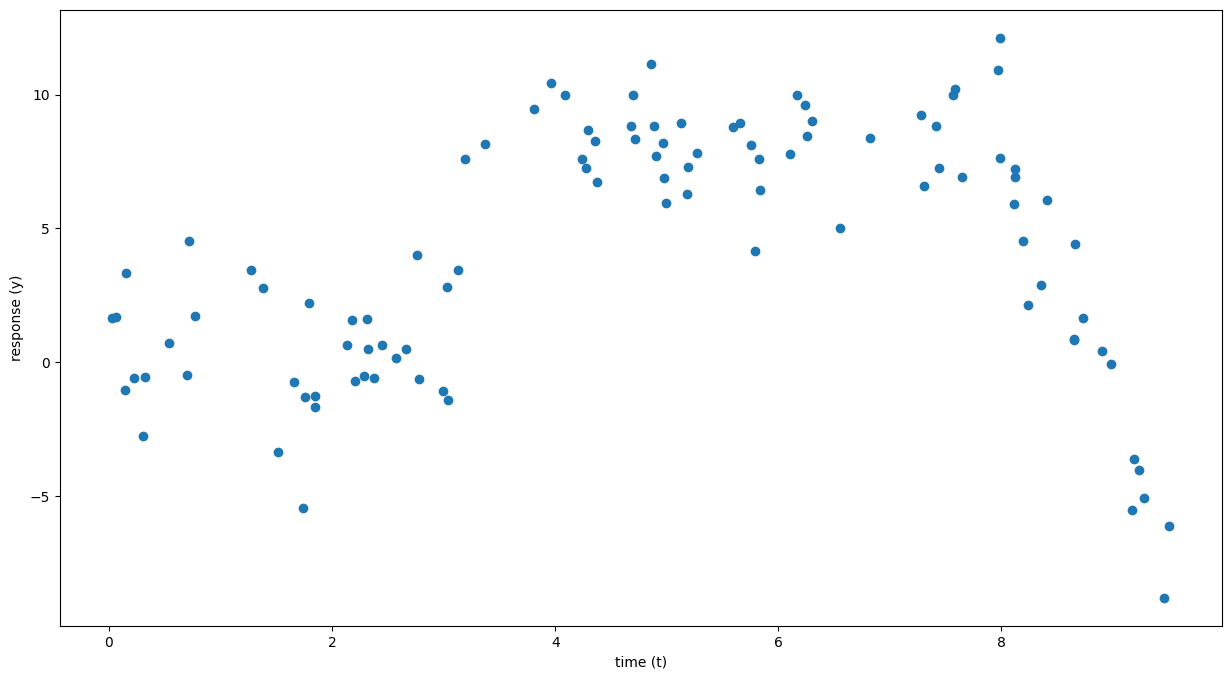

In [4]:
plt.scatter(df['t'], df['y'])
plt.xlabel("time (t)"); plt.ylabel("response (y)");

Does the right answer look like this?

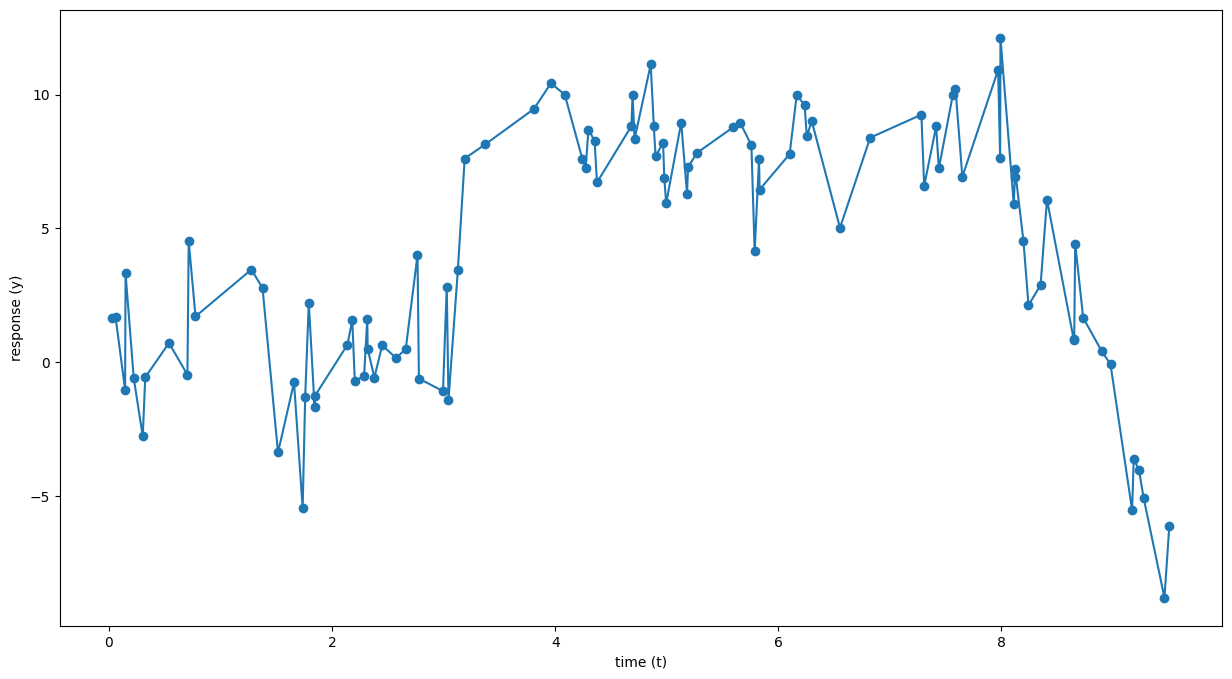

In [5]:
plt.scatter(df['t'], df['y'])
plt.plot(df['t'], df['y'])
plt.xlabel("time (t)"); plt.ylabel("response (y)");

Or like this?

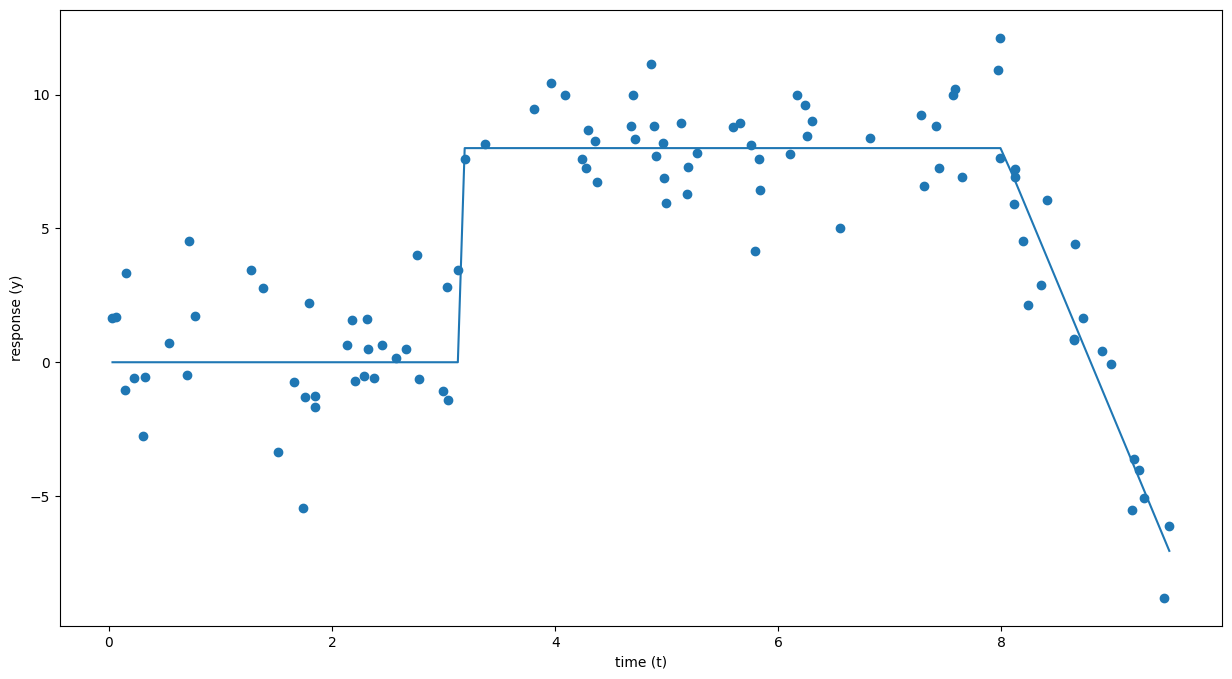

In [6]:
ey = 10 * (1.2 * (x < np.pi) + 2 * np.logical_and(x > np.pi, x < 8) + (10 - x) * (x > 8)) - 12
plt.plot(df['t'], ey)
plt.scatter(df['t'], df['y'])
plt.xlabel("time (t)"); plt.ylabel("response (y)");

Or what?

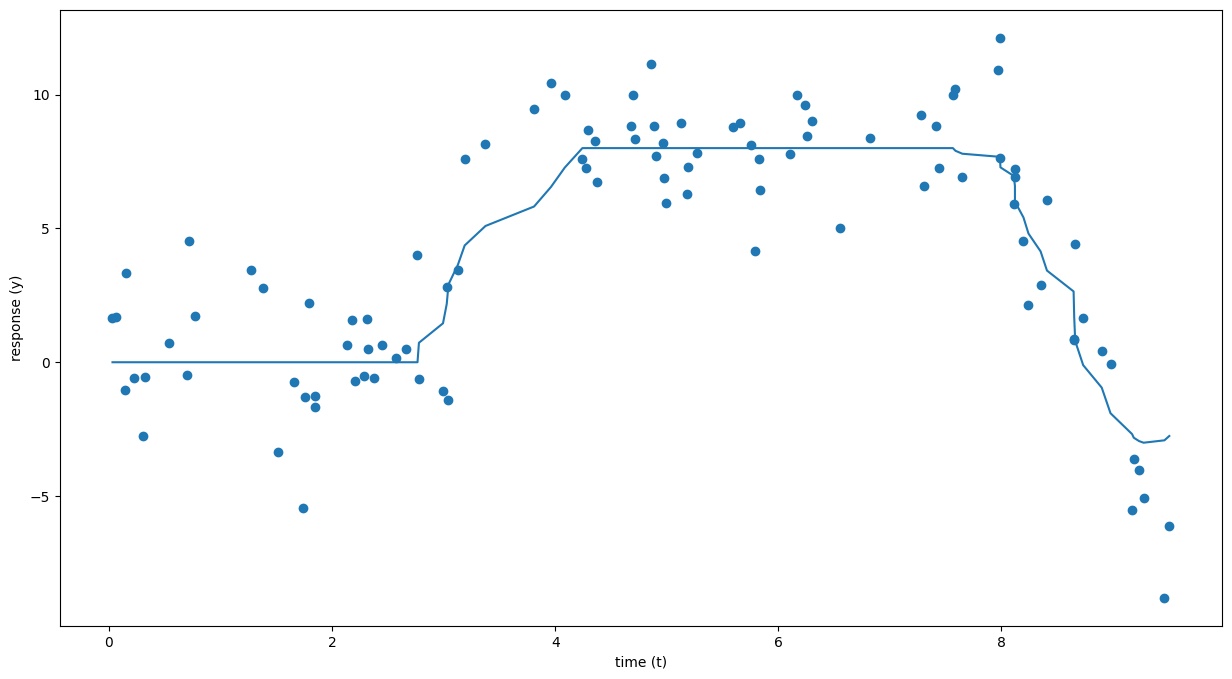

In [7]:
plt.plot(df['t'], np.convolve(ey, np.ones(11)/11)[5:-5])
plt.scatter(df['t'], df['y'])
plt.xlabel("time (t)"); plt.ylabel("response (y)");

# A quick introduction to splines

What we'd like to do is to fit a model like
$$
    y_i = \beta_1 f_1(t_i) + \cdots + \beta_k f_k(t_i) + \epsilon_i ,
$$
where $f_1(t), \ldots, f_k(t)$ are "nice smooth functions".

A good way to get a bunch of "nice smooth functions"
is from a "spline basis", like this one **(thanks, patsy!)**:

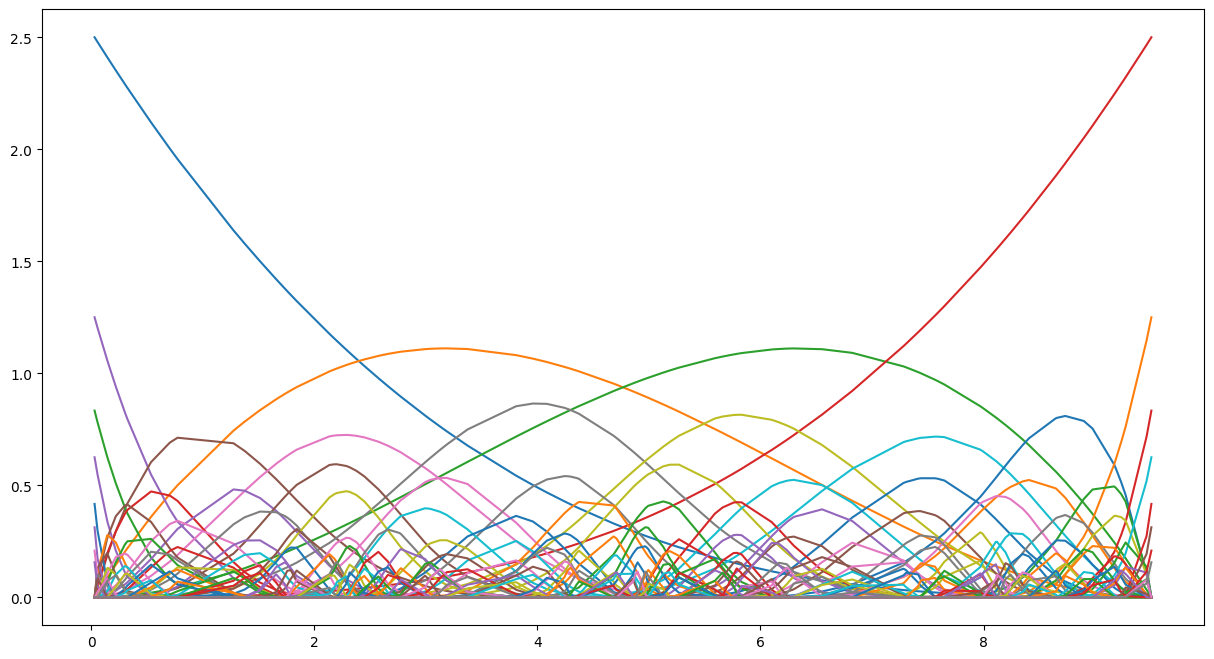

In [8]:
s = np.hstack([
    (10/k) * patsy.dmatrix(f"bs(t, df=k, degree=3, include_intercept=True) - 1", df)
    for k in (4, 8, 12, 16, 24, 32, 48, 64)
])
 
plt.plot(df['t'], s);

By adding up linear combinations of these functions
we can make a pretty wide range of curves.
Here's a few randomly chosen ones:

In [14]:
coefs.shape, s.shape, df.shape

((208, 4), (101, 208), (101, 2))

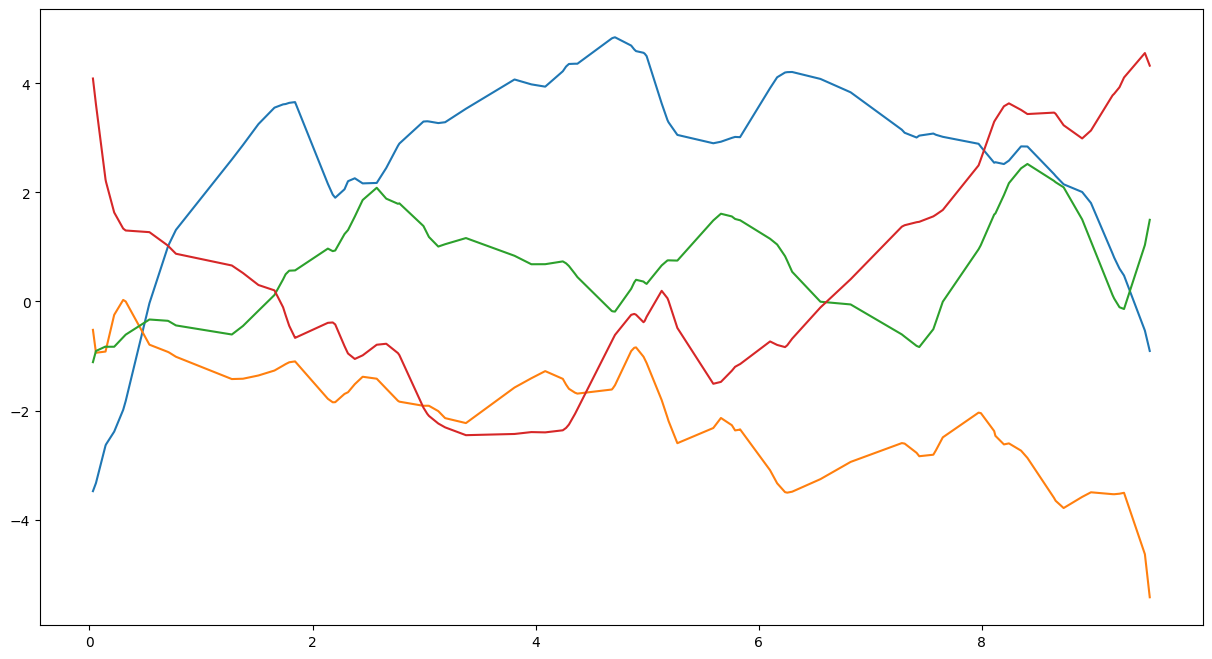

In [10]:
coefs = rng.normal(size=(s.shape[1], 4))
plt.plot(df['t'], s.dot(coefs));

Well, we know how to fit that model!
Least squares, here we come!

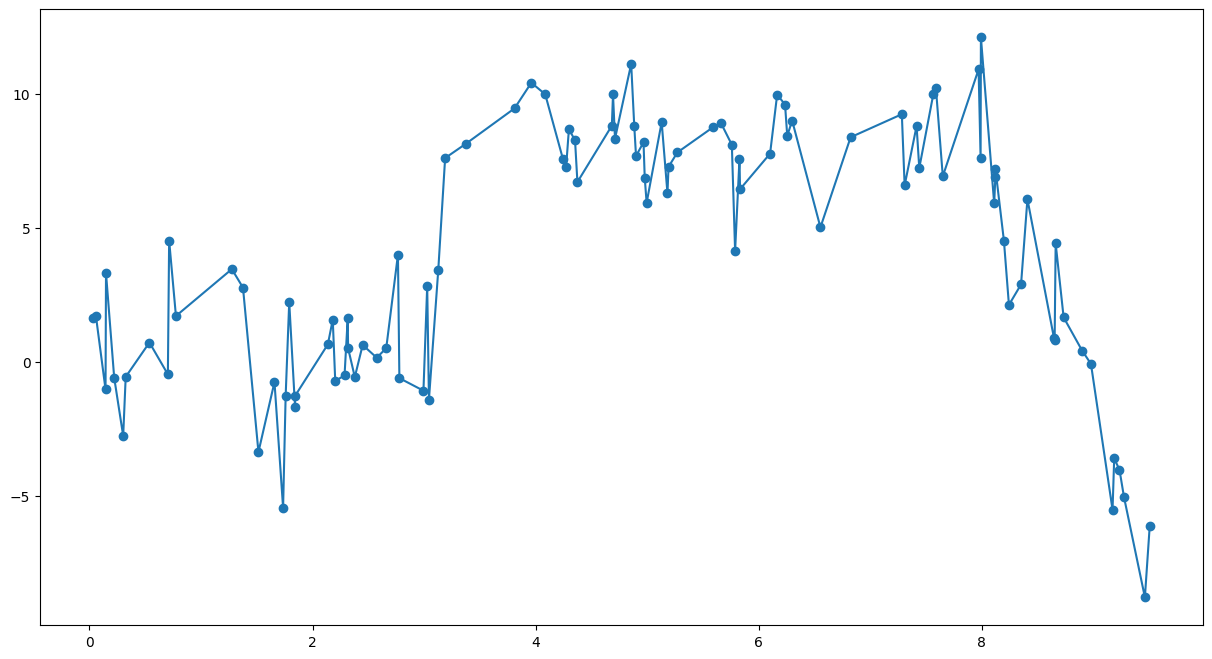

In [15]:
sfit, _, _, _ = np.linalg.lstsq(s, y, rcond=None)

plt.scatter(df['t'], df['y']);
plt.plot(df['t'], s.dot(sfit));

Hm - that looks a bit too... jagged? Overfit, a bit?

# Too many knobs

One problem is that there's too many degrees of freedom -
we're trying to infer 208 parameters with only 101 data points.

But, all those knobs make our inferred curves nice and flexible!
Which ones do we need?

One solution would be to reduce things down to a smaller number of knobs
(i.e., only use a smaller number of basis functions).

Another solution is to adjust our expectations:
never mind, we don't actually want the **best** possible solution,
we just want a pretty good one, please?
And, we'd like it to be reasonable?

# Regularization, again

Recall we're fitting this model:
$$
    y_i = \beta_1 f_1(t_i) + \cdots + \beta_k f_k(t_i) + \epsilon_i ,
$$
which suggests finding $\beta$ to minimize the loss function
$$
    \sum_i \left( y_i - \sum_{j=1}^k \beta_j f_j(t_i) \right)^2 .
$$

To "encourage smoothness" we might add to this a penalty
that depends on the wiggliness of the functions,
say
$$
    + \alpha \sum_j \beta_j^2 \int f_j''(t)^2 dt .
$$

We don't have the information about second derivatives easily available here,
so I've cheated a little in how I set up the functions,
and we can just add a "ridge" penalty to do roughly the same thing:
$$ + \alpha \sum_j \beta_j^2 . $$

Here are results from using the "ridge" regularization,
at different strengths.
Which looks the best?

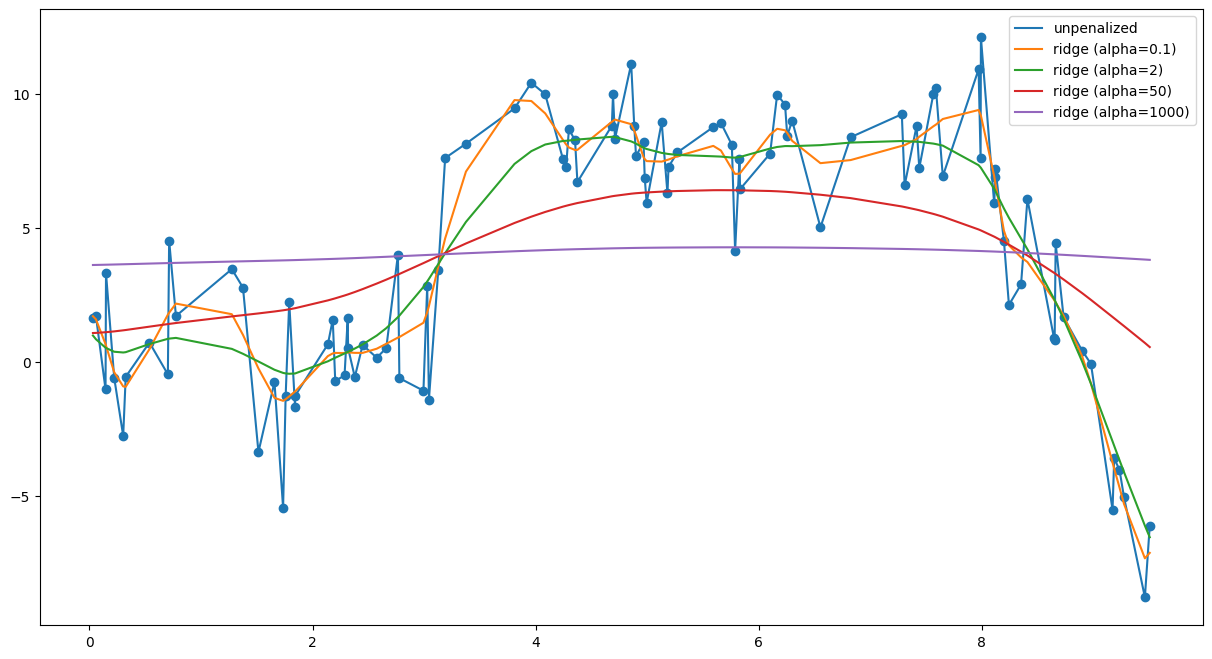

In [16]:
from sklearn.linear_model import Ridge

plt.scatter(df['t'], df['y'])
plt.plot(df['t'], s.dot(sfit), label='unpenalized')
for a in [0.1, 2, 50, 1000]:
    rfit = Ridge(alpha=a).fit(s, y)
    rpred = s.dot(rfit.coef_) + rfit.intercept_
    plt.plot(df['t'], rpred, label=f'ridge (alpha={a})');
plt.legend();

How do we find a good strength of regularization?
Crossvalidation!

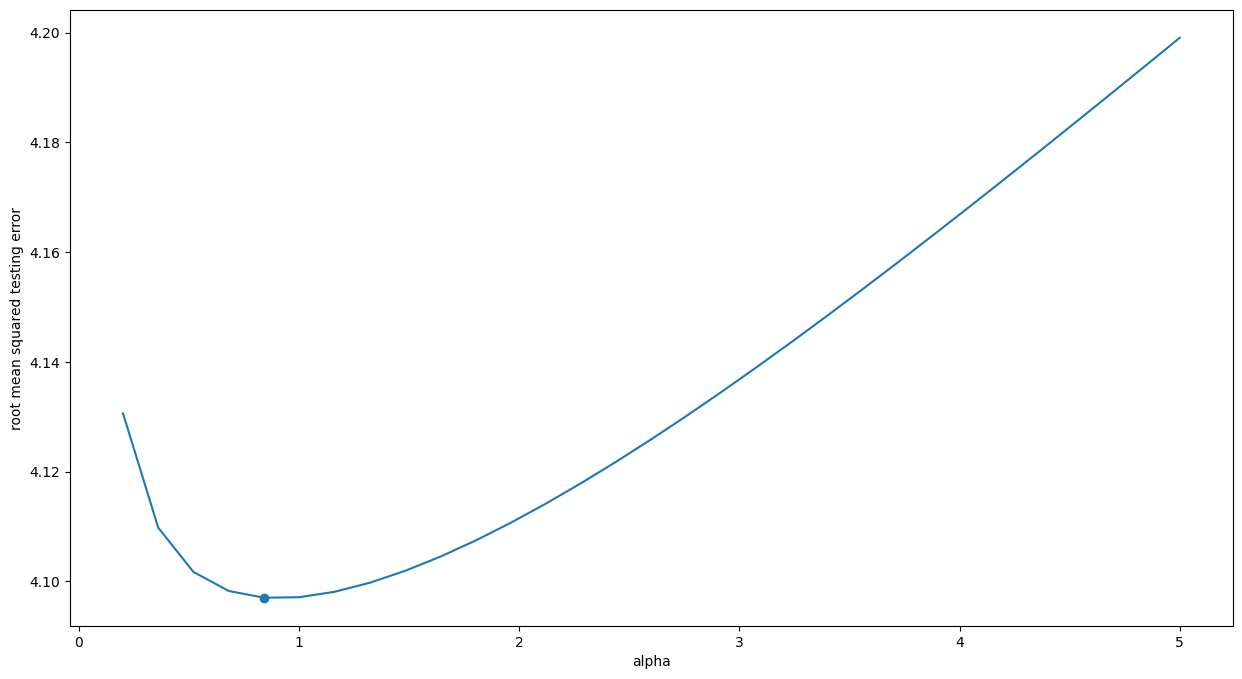

In [21]:
def do_xval(alpha, test):
    rfit = Ridge(alpha=alpha).fit(s[~test,:], y[~test])
    rpred = s.dot(rfit.coef_)
    return np.sqrt(np.mean((y[test] - rpred[test])**2))

def xval(alpha, folds):
    return np.mean([do_xval(alpha, folds==j) for j in np.unique(folds)])

folds = np.repeat(np.arange(10), 11)[:101]
rng.shuffle(folds)

avals = np.linspace(0.2, 5, 31)
mse = np.array([xval(a, folds) for a in avals])
a_min = avals[np.argmin(mse)]

plt.plot(avals, mse);
plt.scatter(a_min, mse[np.argmin(mse)])
plt.xlabel("alpha"); plt.ylabel("root mean squared testing error");

The winner:

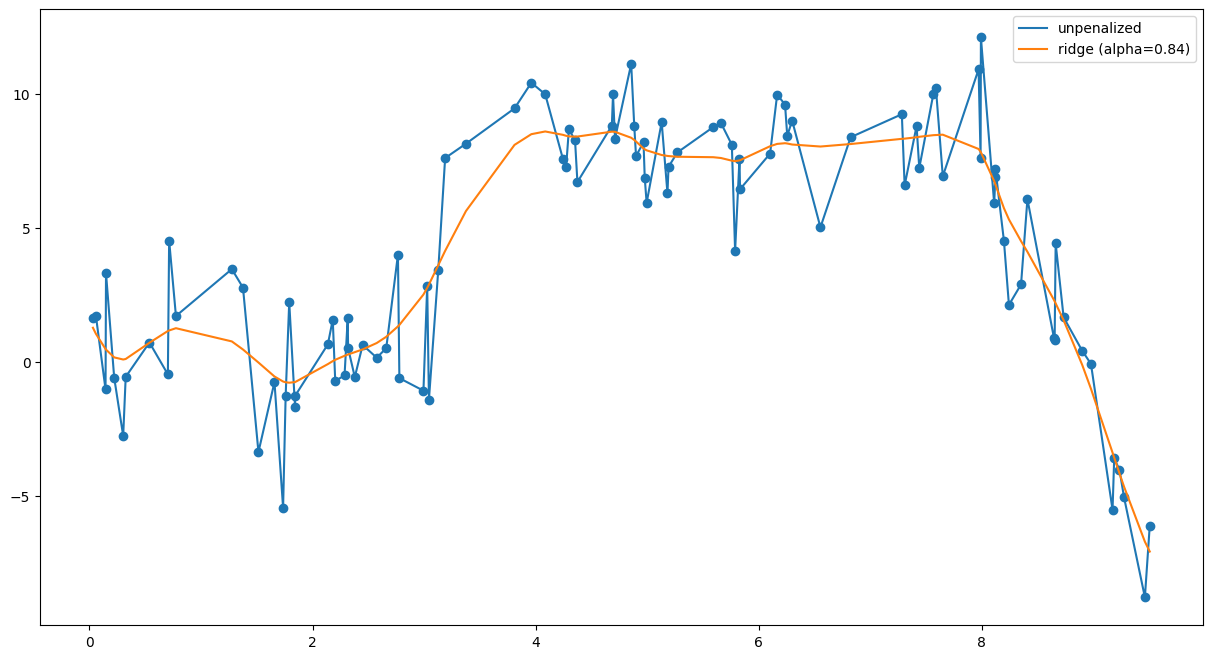

In [22]:
plt.scatter(df['t'], df['y'])
plt.plot(df['t'], s.dot(sfit), label='unpenalized')
rfit = Ridge(alpha=a_min).fit(s, y)
rpred = s.dot(rfit.coef_) + rfit.intercept_
plt.plot(df['t'], rpred, label=f'ridge (alpha={a_min:.4})');
plt.legend();

# What happened there?

We wanted a *flexible* model, where we didn't have to pre-specify a specific, simple form for the answer.

But, "flexible" meant there were lots of good solutions,
and the best solutions were *too* close (suffered from overfitting).
(The inference problem is *ill-posed*.)

So, we had to be clever about how to choose a reasonable solution, out of the many good ones.

This same tension between flexibility and overfitting
is common to many methods in statistics and machine learning.